# Assignment 3: Linear Regression (100 points)

Only use the already imported library `numpy` and the Python standard library. Make sure that the datasets `dataLinReg2D.txt`, `dataQuadReg2D.txt` and `dataQuadReg2D_noisy.txt` are in the same directory as the notebook.


- Group members:
  - Wang, Jiahui - B.Sc.Mathematik - 2992080 \\
  - Zhao, Jiaqi - M.Sc.Autonome System - 3470190 \\
  - Wang, Ziyin - M.Sc.Informatik - 3435397

## Task 1: Linear Regression - theory (10 points)
1) *(4 points)* Linear regression can have nonlinear input features, why is it still called linear regression? In what sense is it linear?

- Linear is not limited by the input, it is linear in the effect of parameters. So nonlinear features can represent polynomials, piece-wise element, spline-basis element and kernes of the original input data.

2) *(3 points)* For calculating optimal parameters $\hat{\beta}$ the inverse of $X^{\top}X$ has to be calculated. When would this matrix be singular?

- When this matrix is a square matrix with linearly dependent columns, then it would be singular.

3) *(3 points)* Why does the optimization problem for $L_1$-regularization (Lasso) not have a closed form solution?

- Because the L1-regularization use the absolute value, so the function is not differentiable. It needs some quadratic programming.

## Task 2: Ridge Regression for Polynomial 2D Functions (70 points)
Each line in the data sets consists of a data entry `(x,y)` with a 2D point `x` and a 1D function output `y`.

In [ ]:
# Load required packages and datasets. Do not modify.
import numpy as np


def load_dataset(path):
    data = np.loadtxt(path)
    X, y = data[:, :2], data[:, 2]
    
    return X, y
    

X_lin, y_lin = load_dataset("dataLinReg2D.txt")
X_quad, y_quad = load_dataset("dataQuadReg2D.txt")
X_noise, y_noise = load_dataset("dataQuadReg2D_noisy.txt")

OSError: ignored

1) *(5 points)* Draw random samples from the dataset for training, use 70% of the data. Do not modify the interface of the function. Do this for `X_quad` and `X_noise`.

In [ ]:
def train_split(X, y, test_split = 0.7):
    """
    Returns X_train, y_train
    where X_train are random samples of X and y_train are the corresponding true values.
    test_split represents the persentage of how many training samples are drawn from X.
    """
    # Calculate the size of training set
    L = len(X)
    Training_size = int(test_split * L) 
    # Shuffle the index randomly and choose the first 70% as Training set
    Index = np.arange(L)
    Training_index = np.random.choice(Index,Training_size,replace = False)
    # Split the dataset
    X_train = X[Training_index,:]
    y_train = y[Training_index]
    return X_train, y_train

X_quad_train, y_quad_train = train_split(X_quad, y_quad)
X_noise_train, y_noise_train = train_split(X_noise, y_noise)

2) *(10 points)* Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`).

In [ ]:
def make_features(X, ftype='lin'):
    """
    generates features from input data, returns Phi.
    ftype is used to distinguish types of features
    """
    n, d = X.shape
    
    if ftype == 'lin': 
        # Linear feature transformation (including intercept)
        Phi = np.empty((n, d+1))
        Phi[:, 0] = 1
        Phi[:, 1:] = X
        
    elif ftype == 'quad':
        # Quadratic feature transformation
        Phi = np.empty((n, d+1))
        Phi[:, 0] = 1
        Phi[:, 1:d+1] = X
        for i in range(d):
            Phi = np.append(Phi, np.diag(X[:,i]) @ X[:,i:], axis=1) 
    else:
        raise Exception(f'Feature type {ftype} not implemented yet')
    return Phi

print(make_features(X_noise,ftype = 'quad'))

[[ 1.00000000e+00 -5.18880000e-01  8.85183000e-01  2.69236454e-01
  -4.59303755e-01  7.83548943e-01]
 [ 1.00000000e+00 -1.77407000e+00  2.59701000e+00  3.14732436e+00
  -4.60727753e+00  6.74446094e+00]
 [ 1.00000000e+00  2.85710000e-01  2.78883000e-01  8.16302041e-02
   7.96796619e-02  7.77757277e-02]
 [ 1.00000000e+00 -1.27392000e+00 -1.63446000e+00  1.62287217e+00
   2.08217128e+00  2.67145949e+00]
 [ 1.00000000e+00  1.94745000e+00 -4.29195000e-01  3.79256150e+00
  -8.35835803e-01  1.84208348e-01]
 [ 1.00000000e+00  2.43402000e-01  1.22919000e+00  5.92445336e-02
   2.99187304e-01  1.51090806e+00]
 [ 1.00000000e+00 -9.84818000e-01  1.58151000e+00  9.69866493e-01
  -1.55749952e+00  2.50117388e+00]
 [ 1.00000000e+00 -1.21915000e+00  8.90071000e-01  1.48632672e+00
  -1.08513006e+00  7.92226385e-01]
 [ 1.00000000e+00  4.81370000e-01  4.68678000e-01  2.31717077e-01
   2.25607529e-01  2.19659068e-01]
 [ 1.00000000e+00 -4.21353000e-01  3.23877000e-01  1.77538351e-01
  -1.36466546e-01  1.0489

3) *(10 points)* Implement Ridge Regression to fit a polynomial function to the data sets with the regularization parameter `lambda_` and feature type `ftype`.

Fill out the methods in `RidgeRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`. Before calculating the inverse check if the determinant is non-zero.

In [ ]:
class RidgeRegression(object):
    def __init__(self, lambda_, ftype = 'lin'):
        self.lambda_ = lambda_
        self.ftype = ftype
        self.beta = None  # Learned regression coefficients.
    
    def fit(self, X, y):
        """
        X is an array of shape (n, d), 
            where n is the number of samples and d is the number of features.
        y is an array of shape (n,)
        """
        Phi = make_features(X, self.ftype)

        d = Phi.shape[1]
        I = np.identity(d)

        M = Phi.T @ Phi + self.lambda_  * I 

        if np.linalg.det(M) != 0:
            self.beta = np.linalg.inv(M) @ Phi.T @ y
        else:
            raise Exception("X does't have full rank, so Rigde Regression cannot be implemented.")

        
    def predict(self, X):
        """
        X is an array with shape (n, d).
        The method returns an array of shape (n,).
        """
        Phi = make_features(X, self.ftype)
        
        return Phi.dot(self.beta)

4) *(5 points)* Implement the function `MSE` to compute the mean squared error. `y_pred` and `y_true` are the vectors of predicted and true function outputs respectively with shape `(n,)`, where `n` is the number of samples. The function returns a single float.

In [ ]:
def MSE(y_pred, y_true):
    """
    return the mean squared error of y_pred and y_true
    """
    E = y_pred - y_true
    return np.mean(E*E)

5) *(30 points)* Evaluate your Ridge Regression model with linear features on the linear `(X_lin, y_lin)` data set. Report the MSE on the full data set when trained on the full dataset. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. print the minimal `lambda_`.

How does it perform with quadratic features on this data set?

l=2.5e-06
MSE: 0.0102479814537021, feature type: lin
l=5e-06
MSE: 0.010247981453707975, feature type: lin
l=7.500000000000001e-06
MSE: 0.010247981453717773, feature type: lin
l=1e-05
MSE: 0.010247981453731491, feature type: lin
l=2.5e-05
MSE: 0.010247981453896115, feature type: lin
l=5e-05
MSE: 0.010247981454484046, feature type: lin
l=7.500000000000001e-05
MSE: 0.010247981455463928, feature type: lin
l=0.0001
MSE: 0.010247981456835767, feature type: lin
l=0.00025
MSE: 0.010247981473297741, feature type: lin
l=0.0005
MSE: 0.010247981532090023, feature type: lin
l=0.00075
MSE: 0.010247981630076192, feature type: lin
l=0.001
MSE: 0.010247981767255459, feature type: lin
l=0.0025
MSE: 0.010247983413341922, feature type: lin
l=0.005
MSE: 0.01024798929174071, feature type: lin
l=0.0075
MSE: 0.010247999088106797, feature type: lin
l=0.01
MSE: 0.010248012801650608, feature type: lin
l=0.025
MSE: 0.01024817729945113, feature type: lin
l=0.05
MSE: 0.010248764310872904, feature type: lin
l=0.0750

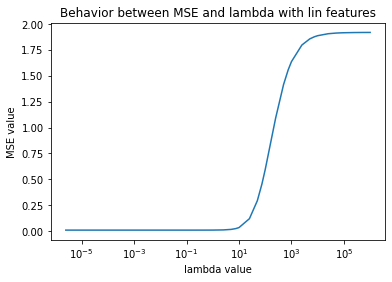

l=2.5e-06
MSE: 0.009745481794487684, feature type: quad
l=5e-06
MSE: 0.009745481794494968, feature type: quad
l=7.500000000000001e-06
MSE: 0.009745481794507101, feature type: quad
l=1e-05
MSE: 0.009745481794524086, feature type: quad
l=2.5e-05
MSE: 0.00974548179472794, feature type: quad
l=5e-05
MSE: 0.009745481795455977, feature type: quad
l=7.500000000000001e-05
MSE: 0.009745481796669371, feature type: quad
l=0.0001
MSE: 0.009745481798368124, feature type: quad
l=0.00025
MSE: 0.00974548181875299, feature type: quad
l=0.0005
MSE: 0.009745481891555233, feature type: quad
l=0.00075
MSE: 0.009745482012890556, feature type: quad
l=0.001
MSE: 0.009745482182757538, feature type: quad
l=0.0025
MSE: 0.009745484221044287, feature type: quad
l=0.005
MSE: 0.009745491499770132, feature type: quad
l=0.0075
MSE: 0.009745503629236298, feature type: quad
l=0.01
MSE: 0.009745520608016776, feature type: quad
l=0.025
MSE: 0.009745724236504561, feature type: quad
l=0.05
MSE: 0.009746450613500835, feature

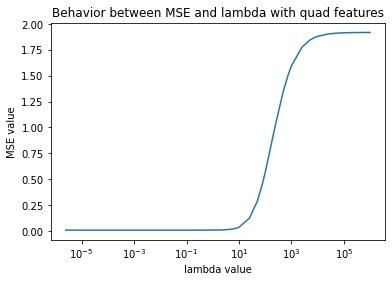

This algorithum with given set of lambda performs better with quadratic performs than with linear features.


In [ ]:
import matplotlib.pyplot as plt
"""
We have change the whole interface of the predefined function, since the original structure is not efficient.
Why is yhat only calculated but not stored or output in the function train_evaluate?
The interface of plot_data_and_model is also not clear...
"""
def train_evaluate_with_result(regression_model, X_fit, y_fit, X, y, p_flag = True):
    """
    Use X and y to fit the regression_model and make prediction over the same dataset.
    Print the error
    Return the prediction and the error
    """
    regression_model.fit(X_fit, y_fit)
    yhat = regression_model.predict(X)
    Loss = MSE(yhat, y)
    if p_flag == True:
        print("l={}".format(regression_model.lambda_))
        print(f'MSE: {Loss}, feature type: {regression_model.ftype}')   
    return yhat, Loss

def optimize_lambda(lambda_set, X_fit, y_fit, X, y, ftype, p_flag = True):
    # Comput the loss value according to each lambda and store them in a vector
    losses = np.empty((len(lambda_set)))
    for i,l in enumerate(lambda_set):
        regression_model = RidgeRegression(l,ftype)
        _,losses[i] = train_evaluate_with_result(regression_model,  X_fit, y_fit, X, y, p_flag)

    # Comput and print the minimal lambda and its loss
    index = np.argmin(losses)
    l_min, loss_min = lambda_set[index], losses[index]
    print("The Minimum loss with {} features is {}, with lambda = {}".format(ftype, loss_min, l_min))

    # Plot the MSE with variable lambda
    plt.plot(lambda_set, losses)
    plt.xscale('log')
    plt.title('Behavior between MSE and lambda with {} features'.format(ftype))
    plt.xlabel('lambda value')
    plt.ylabel('MSE value')
    plt.show()

    return l_min, loss_min, losses

def plot_data_and_model(regression_model, X, y):
    """
    Generates a 3D plot of the regression result with a prefit regression_model 
    including the true underlying data.
    The data points are indicated by circles, the prediction is shown as a surface
    """
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle(f'{regression_model.ftype} Features')
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], y, marker = 'o')
    
    x_min = X.min(0)
    x_max = X.max(0)

    x0_grid, x1_grid = np.mgrid[x_min[0]:x_max[0]:.3, x_min[1]:x_max[1]:.3]

    x_dim_0, x_dim_1 = np.shape(x0_grid)
    x_size = np.size(x0_grid)

    x0_hat = x0_grid.flatten()
    x1_hat = x1_grid.flatten()
    x0_hat = x0_hat.reshape((np.size(x0_hat), 1))
    x1_hat = x1_hat.reshape((np.size(x1_hat), 1))
    x_hat = np.append(x0_hat, x1_hat, 1)
    x_hat_fv = make_features(x_hat, regression_model.ftype)
    y_hat = x_hat_fv.dot(regression_model.beta)
    y_grid = y_hat.reshape((x_dim_0, x_dim_1))
    ax.plot_wireframe(x0_grid, x1_grid, y_grid)
    ax.auto_scale_xyz([x_min[0], x_max[0]], [x_min[1], x_max[1]], [y.min(), y.max()])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$y$')
    

# Generate set of lambda
coefficient_list = [0.25,0.5,0.75,1]
power_range = [-5,7]
lambda_set = np.array([x*(10**k) for k in range(power_range[0],power_range[1]) for x in coefficient_list ])

# Evaluate Ridge Regression model on the linear (X_lin, y_lin)
optimize_lambda(lambda_set,  X_lin, y_lin,X_lin, y_lin, "lin")

# Evaluate Ridge Regression model on the linear (X_lin, y_lin) with quadratic features
optimize_lambda(lambda_set,  X_lin, y_lin,X_lin, y_lin, "quad")

# Compare the result with both features
print("This algorithum with given set of lambda performs better " 
                   "with quadratic performs than with linear features.")


    



6) *(5 points)* Evaluate the quadratic dataset `(X_quad, y_quad)` for different values of `lambda_`. Report the MSE on the full data set when trained on the partial dataset `(X_quad_train, y_quad_train)`. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. print the minimal `lambda_`.

Plot the surface and data points of the best `lambda_` value using the function `plot_data_and_model`.

The Minimum loss with quad features is 0.012464417534335779, with lambda = 2.5e-06


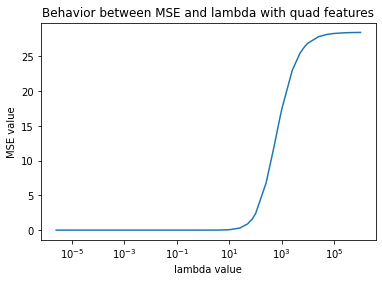

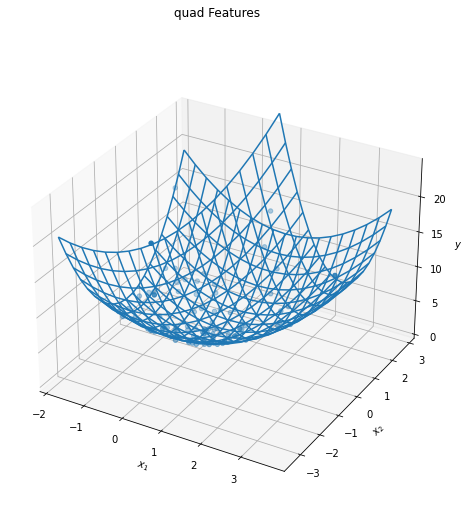

In [ ]:
# Now try use quadratic features
l_min,_,_ = optimize_lambda(lambda_set, X_quad_train, y_quad_train, X_quad, y_quad, "quad",p_flag=False)

# Plot 3D-picture
regression_model_quad = RidgeRegression(l_min, ftype = 'quad')
regression_model_quad.fit(X_quad_train, y_quad_train)
plot_data_and_model(regression_model_quad,X_quad, y_quad)


7) *(5 points)* Evaluate the noisy dataset `(X_noise, y_noise)` for different values of `lambda_`. Report the MSE on the full data set when trained on the partial dataset `(X_noise_train, y_noise_train)`. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis.

Plot the surface and data points of the best `lambda_` value using the function `plot_data_and_model`.

The Minimum loss with quad features is 32.103353557695165, with lambda = 7.5


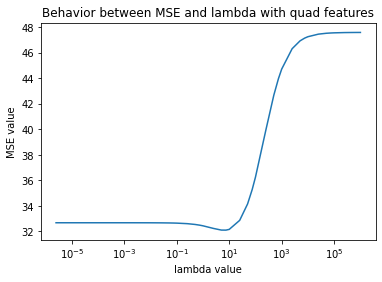

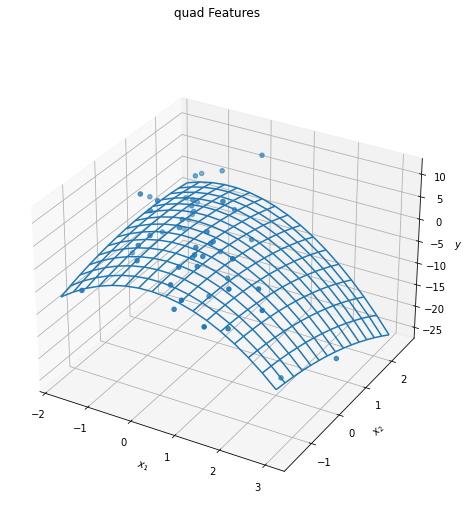

In [ ]:
# Now try use quadratic features with noise
optimize_lambda(lambda_set, X_noise_train, y_noise_train, X_noise, y_noise,"quad",p_flag=False)

# Plot 3D-picture
regression_model_quad = RidgeRegression(l_min,ftype = 'quad')
regression_model_quad.fit(X_noise_train, y_noise_train)
plot_data_and_model(regression_model_quad, X_noise, y_noise)

## Task 3 Evaluation (20 points)

1) *(5 points)* What was the best choice for regularization term `lambda_` in the models above? Explain the observation from the previous task? If `lambda_` is set to zero $\hat{\beta}$ is not regularized, when would $\lambda = 0$ be a good choice?

- The best choice for lambda_ is 2.5e-06 in the models above.
- This algorithm with the given set of lambda performs better with quadratic performs than with linear features.
- When training only focuses on minimizing the loss, maybe  λ=0  can be a good choice.


**For all students other than B.Sc. Data Science:** 

2) *(15 points)* Implement the function `cross_validation` for `k_fold = 10` to evaluate the prediction error of your model. Report the mean squared error from cross-validation. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. 

In [ ]:
def cross_validation(regression_model, X, y, k_fold = 10):
    """
    partition data X in k_fold equal sized subsets D = {D_1, ..., D_{k_fold}}, 
        fit the model on k_fold-1 subsets (D\D_i), 
        compute MSE on the evaluatin set (D_i),
        return the mean MSE over all subsets D
    """
    # Split index in k_fold parts and store the partition in a list
    m = int(len(X)/k_fold)
    divided_index = []
    for i in range(0,len(X),m):
        divided_index.append(range(len(X))[i:i+m])

    # Conduct cross validation for each partition
    cross_losses = np.empty((k_fold))
    for i in range(k_fold):
        local_train_index = [ind for j in range(k_fold) for ind in divided_index[j] if j != i]
        local_test_index  =  divided_index[i]
        local_X_train     = X[local_train_index]
        local_X_test      = X[local_test_index]
        local_y_train     = y[local_train_index]
        local_y_test      = y[local_test_index]

        _, cross_losses[i] = train_evaluate_with_result(regression_model,local_X_train, \
                                                    local_y_train,local_X_test,local_y_test,p_flag=False)

    return np.mean(cross_losses)

The Minimum cross_loss with linear features is 0.01091144740435184, with lambda = 2.5e-06


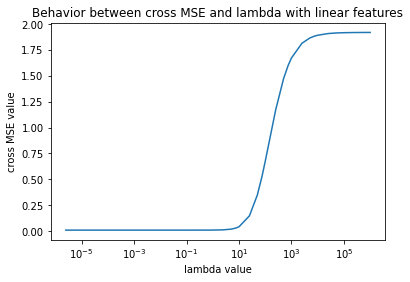

In [ ]:
losses = np.empty((len(lambda_set)))
for i,l in enumerate(lambda_set):
    regression_model = RidgeRegression(l,ftype="lin")
    losses[i] = cross_validation(regression_model,  X_lin, y_lin)

# Comput and print the minimal lambda and its loss
index = np.argmin(losses)
l_min, loss_min = lambda_set[index], losses[index]
print("The Minimum cross_loss with linear features is {}, with lambda = {}".format(loss_min, l_min))

# Plot the cross MSE with variable lambda
plt.plot(lambda_set, losses)
plt.xscale('log')
plt.title('Behavior between cross MSE and lambda with linear features')
plt.xlabel('lambda value')
plt.ylabel('cross MSE value')
plt.show()
